In [1]:
pwd

'/Users/edwardterrell/Desktop/covid_machinations'

In [2]:
# this block is used for copying/moving files
import os
import shutil
import time
#shutil.copyfile('src', 'dst')
#shutil.move

# we want to ensure we are in the correct conda environment
import sys
sys.executable

'/Users/edwardterrell/opt/anaconda3/envs/dataviz/bin/python'

In [3]:
# This is a custom python module with dictionaries of states and countries; 
# it also contains three functions repair_dict, reverse_dict, and custom_list
import state_country_dicts as scd

In [4]:
# provides ability to reload modules (wihtout leaving jupyter) if changes are made
import importlib
#importlib.reload(scd)

In [5]:
import numpy as np
import pandas as pd

In [6]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt

import requests
from bs4 import BeautifulSoup as bs
# import regular expressions
import re 

from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

### Cornavirus section

In [7]:
# get current date for use in creating filenames with embedded 'day'. 
# convert datetime object to string
import datetime as dt
today  = dt.date.today()
day = today.strftime('%Y-%m-%d')
day

'2021-12-22'

In [9]:
print ('If using Binder enter a timezone difference from UTC')
timezone = input(' Enter a number between 12 and -12:')
print(timezone)
if timezone:
    timezone = int(timezone)
    v = scd.tz_dict[timezone]
    t = pd.Timestamp.today(v)
    print (t)
    day = t.date().strftime('%Y-%m-%d')
day

If using Binder enter a timezone difference from UTC


 Enter a number between 12 and -12: 


'2021-12-22'

### Moves all files from covid_data_update to covid_data 

In [34]:
# Ensure helper files used in past have been removed
!rm -f covid_data/covid_text covid_data/flist_of_covid_png covid_data/temp.xlsx

In [35]:
!mkdir covid_data_update

mkdir: covid_data_update: File exists


In [11]:
# House keeping covid_data_update folder
# preparing the move of all files from covid_data_update to covid_data 
# so that we are left with an empty covid_date_update folder
file_names = []
source_dir = 'covid_data_update'
target_dir = 'covid_data'
print("covid_data_update directory contents:") 
file_names = os.listdir(source_dir)
print (file_names)
if file_names == []:
    print ('Directory is empty so no files available to move')

covid_data_update directory contents:
[]
Directory is empty so no files available to move


In [12]:
# The below cell will move and archive all files in covid_data_update to covid_data

In [13]:
%%capture
# Move contents of source ('covid_data_update')to target ('covid_data')
for file_name in file_names:
    shutil.move(os.path.join(source_dir, file_name), target_dir)

In [14]:
def clean_up (number_str):
    '''This is a clean up routine so that only numeric characters remain'''
    number_str = number_str.replace(',', '').replace('null','0').rstrip(']').lstrip("'")
    return int(number_str)

### Custom state dictionaries

In [15]:
# creates a custom state dict
s_string = input('Enter state codes seperated by a space:') or 'ca tx fl az co ny il'
print()

slist = scd.custom_list (s_string)
state_dict = {key: value for key, value in scd.all_states.items() if value in slist}
state_dict

Enter state codes seperated by a space: 


{'arizona': 'AZ',
 'california': 'CA',
 'colorado': 'CO',
 'florida': 'FL',
 'illinois': 'IL',
 'new-york': 'NY',
 'texas': 'TX'}

### State Scraping section

In [16]:
# The start dates for U.S.states and for countries are different so must be accounted for
st_start = pd.Timestamp('2020/3/13')
c_start = pd.Timestamp('2020/2/16')

# set end time to yesterday

#day == pd.Timestamp.today().strftime('%Y-%m-%d')
end = pd.Timestamp.today() - pd.Timedelta(days=1)
print(f'end changed to yesterday: {end}')
#else:
#   end = pd.Timestamp.today()
#    print(f'end changed to {end}')
    
# set the index to the appropriate date range for states and countries
st_index = pd.date_range(st_start, end)
c_index = pd.date_range(c_start, end)
len(st_index)
len(c_index)

# list comprehension to extract just the state initials from the dict
st_list = list(state_dict.values())

# create an empty pandas df with column headers from state_dict
state = pd.DataFrame(columns = st_list,index=st_index)
state.sort_index(ascending = False).head()
state.shape

end changed to yesterday: 2021-12-21 15:36:57.016162


649

675

,AZ,CA,CO,FL,IL,NY,TX
2021-12-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(649, 7)

In [17]:
state_url='https://www.worldometers.info/coronavirus/usa/'
# Here the keys are the state names and the values are the 2-letter abbreviation
for key, value in state_dict.items():
    url = state_url+key

    # scrape web page for state info and assign to soup
    response = requests.get(url)
    #response.status_code
    page = response.text
    soup = bs(page)
    
    # Find block of text/data near 'graph-cases-daily' 
    re_graph = re.compile('graph-cases')
    try:
        data = soup.find(text=re_graph).parent
    except:
        print(f'Unable to find {url}')
        print()
        break
    

    # Regex to pull out data chunk out of the larger soup like data
    myregex = re.compile (r'data:.*\]')
    mo = myregex.search(str(data))

    #mo.group() is a string so easy to get rid of the first entry
    #state_previous_cases is a list of daily new coronavirus cases
    state_previous_cases = mo.group().split(',')[1:]
    len(state_previous_cases)
    
    # ensure match between length of the empty df and the new list
    if len(st_index)!= len(state_previous_cases):
        print (len(st_index))
        print (len(state_previous_cases))
        state_previous_cases = state_previous_cases[:-1]
        print (len(state_previous_cases))
    
    # merge states into the existing df and apply the function clean_up to convert strings to ints
    # state[value] where value is the 2-letter abreviation
    state[value] = state_previous_cases
    state[value] = state[value].fillna(0).apply(clean_up)
    
    time.sleep(2)
state.sort_index(ascending = False).head()   

649

649

649

649

649

649

649

,AZ,CA,CO,FL,IL,NY,TX
2021-12-21,2395,9162,3351,12915,10264,21979,11211
2021-12-20,2176,8134,1174,9435,12328,26393,10759
2021-12-19,2745,9850,1038,9434,7705,21624,6446
2021-12-18,3467,9755,1744,8721,11426,21014,7708
2021-12-17,3686,9125,2438,8787,10765,21444,5361


In [18]:
def list2string(l): 
    ''' This creates a a short string of state/country names 
    used during file save
    '''
    str1 = "_" 
    # return string  
    return (str1.join(l))

States available: ['AZ', 'CA', 'CO', 'FL', 'IL', 'NY', 'TX']



Choose state for rolling averge: az


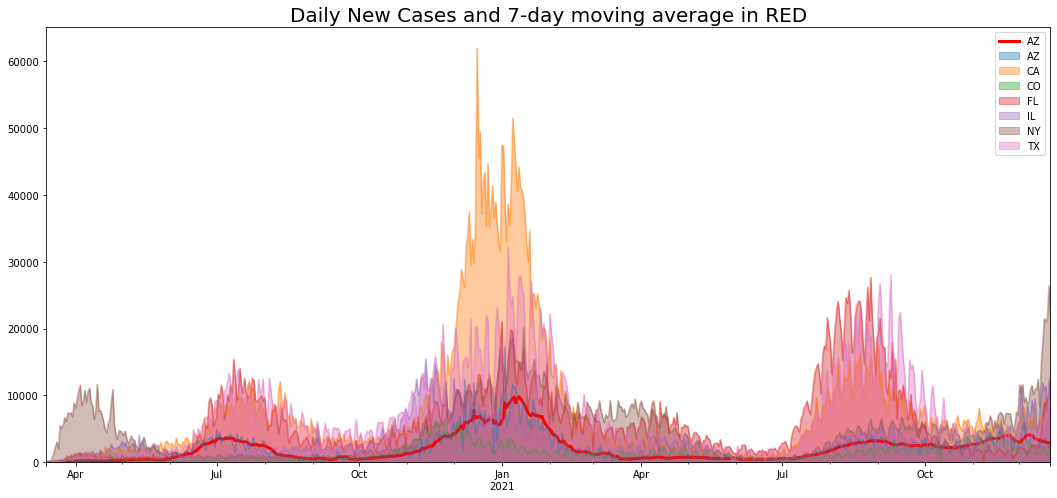

In [19]:
# Allows user to select state for rolling average 
s_available = list(state.columns)
print(f'States available: {s_available}')
print()

snames = (list2string(s_available))

select_state = input('Choose state for rolling averge:')or s_available[0]
select_state = select_state.upper()

if select_state not in s_available:
    select_state = s_available[0]

# Plot Daily New Cases and 7-day moving averge
fig,ax = plt.subplots(1,1,figsize=(18,8))
roll_data = state.loc[:,[select_state]].rolling(window=7).mean()

roll_data.plot(ax=ax, linewidth=3, color='r')
state.plot(kind='area',alpha=.4,ax=ax,stacked=False);
plt.title('Daily New Cases and 7-day moving average in RED', fontsize=20) 

#ax.set_title('Daily New Cases and 7-day moving average in RED', fontsize=20) 
plt.savefig(f'./covid_data_update/us_{day}.png');

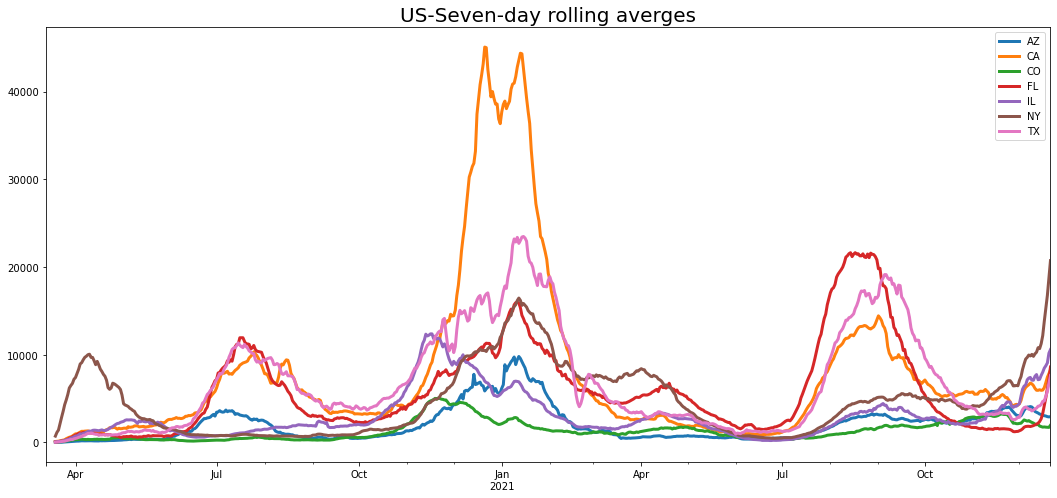

In [20]:
# Plot 7-day moving averge
plt.close('all')
fig,ax = plt.subplots(1,1,figsize=(18,8))
roll_data_all = state.rolling(window=7).mean()
roll_data_all.plot(ax=ax, linewidth=3);
plt.title('US-Seven-day rolling averges',fontsize=20)
plt.savefig(f'./covid_data_update/us_rolling_avg_{day}.png');

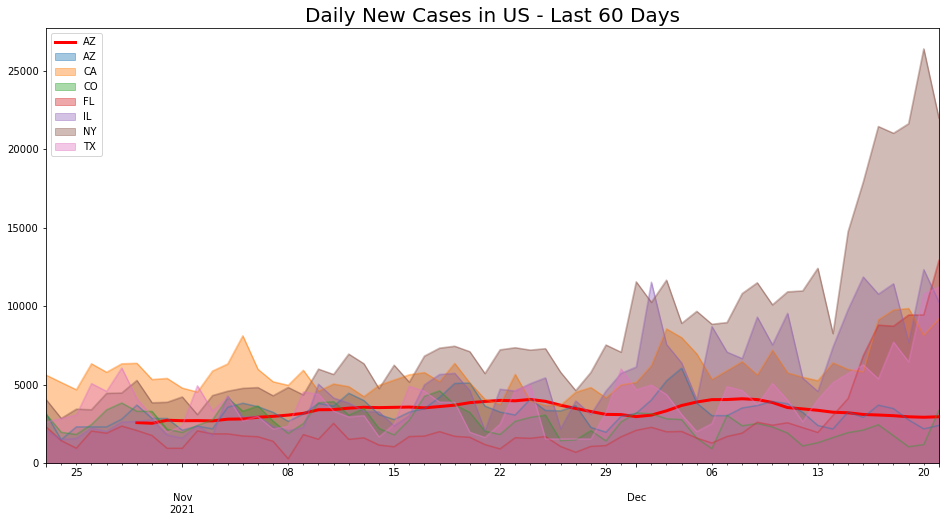

In [21]:
# Plot Last 60 Days
plt.close('all')
# Select last 60 days only
state_last60 = state.tail(60)

roll_data = state_last60.loc[:,[select_state]].rolling(window=7).mean()
fig,ax = plt.subplots(1,1,figsize=(16,8))
roll_data.plot(ax=ax, linewidth=3, color='r')
state_last60.plot(kind='area',alpha=.4,ax=ax,stacked=False);

plt.title('Daily New Cases in US - Last 60 Days',fontsize=20)
plt.savefig(f'./covid_data_update/us_{snames}_last_60_days_{day}.png');

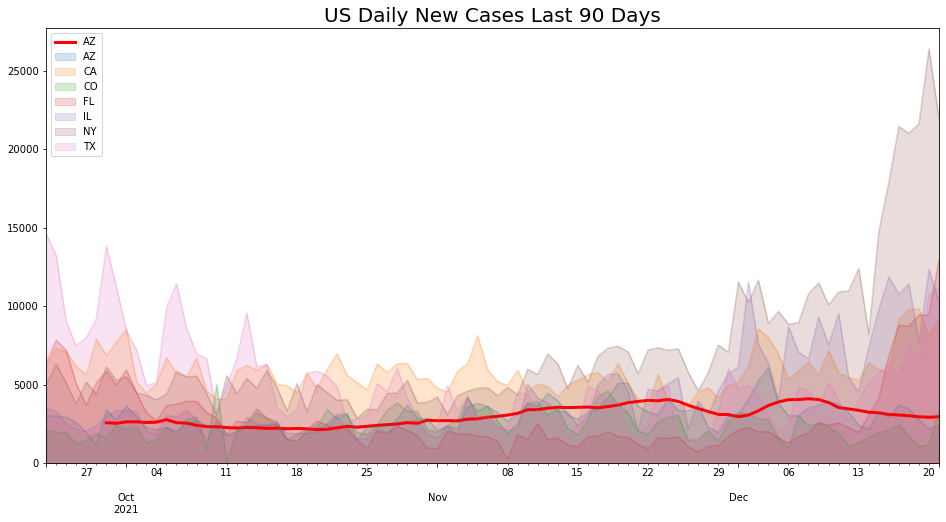

In [22]:
# Plot last 90 days
plt.close('all')
# Select last 90 days only
state_last90 = state.tail(90)

roll_data = state_last90.loc[:,[select_state]].rolling(window=7).mean()
fig,ax = plt.subplots(1,1,figsize=(16,8))
roll_data.plot(ax=ax, linewidth=3, color='r')
state_last90.plot(kind='area',alpha=.2,ax=ax,stacked=False);

plt.title('US Daily New Cases Last 90 Days',fontsize=20)
plt.savefig(f'./covid_data_update/us_{snames}_last_90_days_{day}.png');

In [23]:
# Daily New Cases in tabular format
pd.set_option('display.max_rows', 300)
pd.set_option('display.min_rows', 300)
state.sort_index(ascending = False)

,AZ,CA,CO,FL,IL,NY,TX
2021-12-21,2395,9162,3351,12915,10264,21979,11211
2021-12-20,2176,8134,1174,9435,12328,26393,10759
2021-12-19,2745,9850,1038,9434,7705,21624,6446
2021-12-18,3467,9755,1744,8721,11426,21014,7708
2021-12-17,3686,9125,2438,8787,10765,21444,5361
2021-12-16,2911,5804,2099,6840,11858,17903,6260
2021-12-15,3249,5965,1936,4107,9784,14748,5708
2021-12-14,2168,6381,1622,3032,7390,8243,5120
2021-12-13,2391,5249,1294,1948,4561,12409,4040
2021-12-12,3231,5469,1091,2255,5411,10970,2635


### Custom country dictionaries

In [24]:

# creates a custom country dict
c_string = input('Enter country codes seperated by a space:') or 'fr it es uk de'
clist = scd.custom_list (c_string)

country_dict = {key: value for key, value in scd.all_countries.items() if value in clist}
print(country_dict)

print()

Enter country codes seperated by a space: 


{'germany': 'DE', 'spain': 'ES', 'france': 'FR', 'uk': 'UK', 'italy': 'IT'}



### Scraping section

In [25]:
c_list = list(country_dict.values())
c_list

# create an empty pandas df with column headers from country_dict, using the starting dates for the country as index
country = pd.DataFrame(columns = c_list,index=c_index)
country.sort_index(ascending = False).head()

base_url='https://www.worldometers.info/coronavirus/country/'
# Here the keys are the country names and the values are the 2-letter abbreviation
for key, value in country_dict.items():
    url = base_url+key
    print(url)

    # scrape web page for country info and assign to soup
    response = requests.get(url)
    #response.status_code
    page = response.text
    #print(response.text[:400])
    soup = bs(page)
    
    # Find block of text/data near 'graph-cases-daily' 
    re_graph = re.compile('graph-cases')
    dat = soup.find(text=re_graph)
   
    try:
        data = soup.find(text=re_graph).parent
    except:
        print(f'Unable to find {url}')
        print()
        break

    # Regex to pull out data chunk out of the larger soup like data
    myregex = re.compile (r'data:.*\]')
    mo = myregex.search(str(data))

    #mo.group() is a string so easy to get rid of the first entry
    country_previous_cases = mo.group().split(',')[1:]
    #print(country_previous_cases)
    previous_cases = ["0" if i == 'null' else i for i in country_previous_cases]
    
    len(previous_cases)

    # merge countries into the existing df and apply the function clean_up to convert strings to ints
    country[value] = previous_cases
    country[value] = country[value].fillna(0).apply(clean_up)
    
    time.sleep(2)
country.clip(lower=0,inplace=True) #large negative number removed for better graphic clarity
country.sort_index(ascending = False).head()

['DE', 'ES', 'FR', 'UK', 'IT']

,DE,ES,FR,UK,IT
2021-12-21,NaN,NaN,NaN,NaN,NaN
2021-12-20,NaN,NaN,NaN,NaN,NaN
2021-12-19,NaN,NaN,NaN,NaN,NaN
2021-12-18,NaN,NaN,NaN,NaN,NaN
2021-12-17,NaN,NaN,NaN,NaN,NaN


https://www.worldometers.info/coronavirus/country/germany


675

https://www.worldometers.info/coronavirus/country/spain


675

https://www.worldometers.info/coronavirus/country/france


675

https://www.worldometers.info/coronavirus/country/uk


675

https://www.worldometers.info/coronavirus/country/italy


675

,DE,ES,FR,UK,IT
2021-12-21,35049,49823,72832,90365,30831
2021-12-20,21710,26568,15075,90943,16198
2021-12-19,24190,26568,48473,82083,24251
2021-12-18,30953,26568,58536,89571,28108
2021-12-17,48375,33359,58128,92285,28625


Countries available: ['DE', 'ES', 'FR', 'UK', 'IT']



Choose country for rolling averge: es


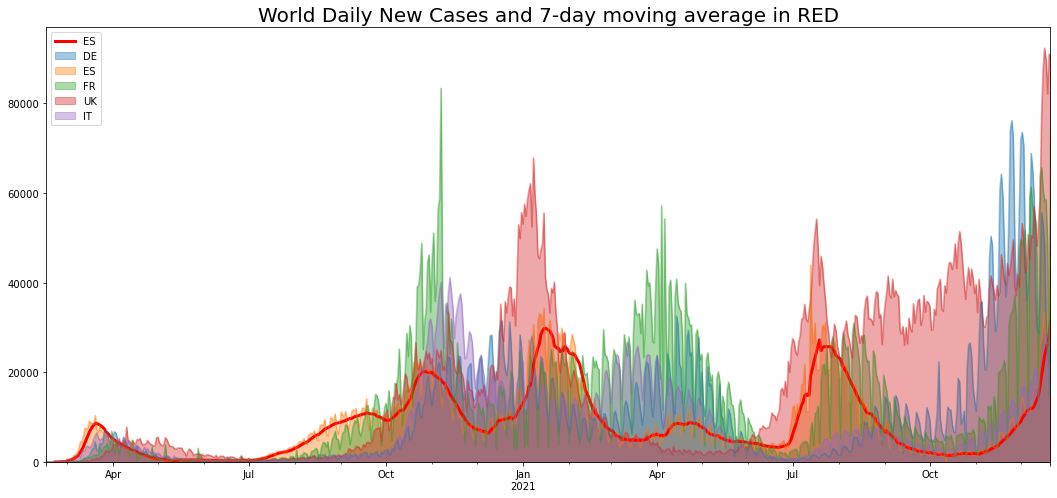

In [26]:
# Allows user to select the country for the rolling average
c_available = list(country.columns)
print(f'Countries available: {c_available}')
print()

snames = (list2string(c_available))

select_country = input('Choose country for rolling averge:') or c_available[0]
select_country = select_country.upper()

if select_country not in c_available:
    select_country = c_available[0]

# Plot Daily New Cases and 7-day moving averge
fig,ax = plt.subplots(1,1,figsize=(18,8))
roll_data = country.loc[:,[select_country]].rolling(window=7).mean()


roll_data.plot(ax=ax, linewidth=3, color='r')
country.plot(kind='area',alpha=.4,ax=ax,stacked=False)
plt.title('World Daily New Cases and 7-day moving average in RED',fontsize=20);
# insert {snames} if desired 
plt.savefig(f'./covid_data_update/world_{day}.png');

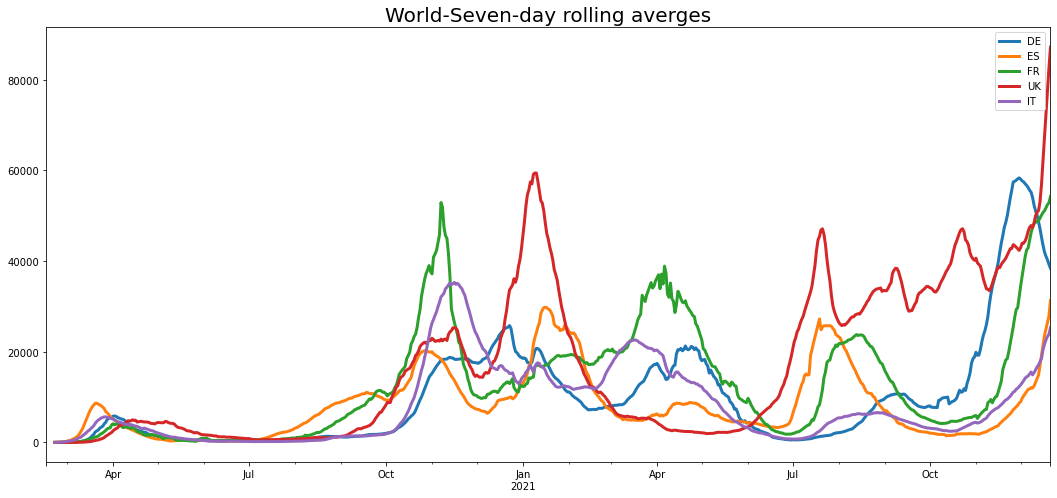

In [27]:
# Plot 7-day moving averge
plt.close('all')
fig,ax = plt.subplots(1,1,figsize=(18,8))
roll_data_all = country.rolling(window=7).mean()
roll_data_all.plot(ax=ax, linewidth=3);
plt.title('World-Seven-day rolling averges',fontsize=20)
# insert {snames} if desired 
plt.savefig(f'./covid_data_update/world_rolling_avg_{day}.png');

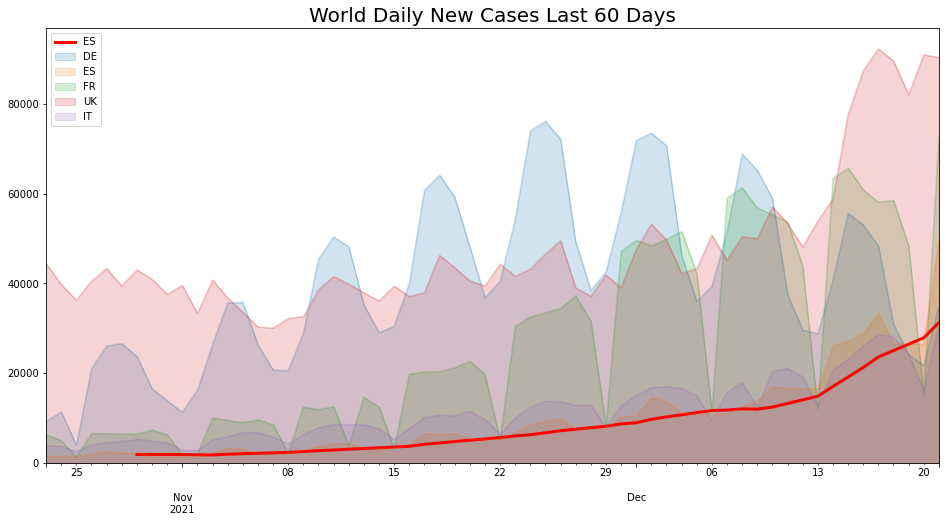

In [28]:
# Plot last 60 days
plt.close('all')
# Select last 60 days only
country_last60 = country.tail(60)

roll_data = country_last60.loc[:,[select_country]].rolling(window=7).mean()
fig,ax = plt.subplots(1,1,figsize=(16,8))
roll_data.plot(ax=ax, linewidth=3, color='r')
country_last60.plot(kind='area',alpha=.2,ax=ax,stacked=False);

plt.title('World Daily New Cases Last 60 Days',fontsize=20)
plt.savefig(f'./covid_data_update/world_{snames}_last_60_days_{day}.png');


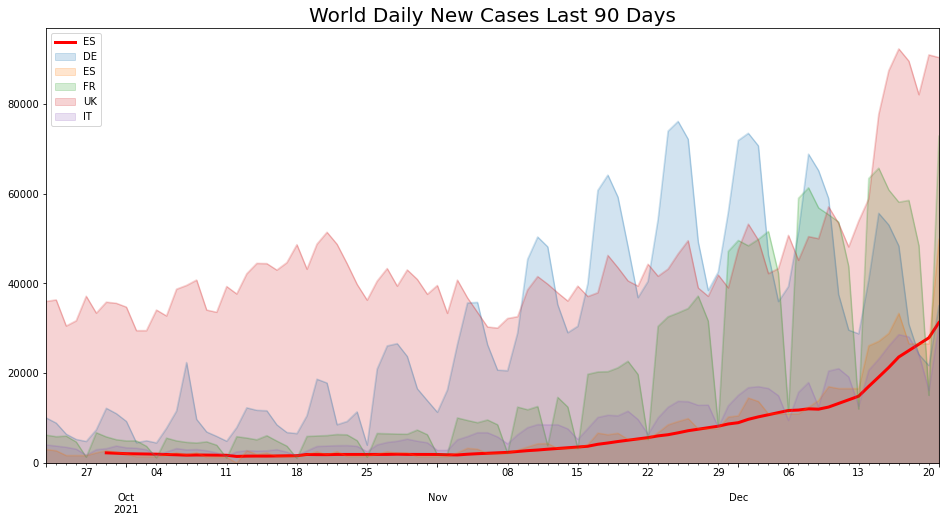

In [29]:
# Plot last 90 days
plt.close('all')
# Select last 90 days only
country_last90 = country.tail(90)

roll_data = country_last90.loc[:,[select_country]].rolling(window=7).mean()
fig,ax = plt.subplots(1,1,figsize=(16,8))
roll_data.plot(ax=ax, linewidth=3, color='r')
country_last90.plot(kind='area',alpha=.2,ax=ax,stacked=False);

plt.title('World Daily New Cases Last 90 Days',fontsize=20)
plt.savefig(f'./covid_data_update/world_{snames}_last_90_days_{day}.png');


In [30]:
# Daily New Cases in tabular format
pd.set_option('display.max_rows', 300)
pd.set_option('display.min_rows', 300)
country.sort_index(ascending = False)

,DE,ES,FR,UK,IT
2021-12-21,35049,49823,72832,90365,30831
2021-12-20,21710,26568,15075,90943,16198
2021-12-19,24190,26568,48473,82083,24251
2021-12-18,30953,26568,58536,89571,28108
2021-12-17,48375,33359,58128,92285,28625
2021-12-16,53057,28900,60866,87438,26092
2021-12-15,55650,27140,65713,77710,23190
2021-12-14,40795,26136,63405,58870,20672
2021-12-13,28804,16600,12036,53923,12700
2021-12-12,29633,16601,43848,48151,19207


### Save merged dataframes to csv

In [31]:
# Merge state and country dfs into one
world = state.merge(country,left_index=True,right_index=True,how='outer')
world = world.fillna(0).astype(int)

In [32]:
# Sorting the table with recent dates on the top
world_table = world.sort_index(ascending = False)

# Save to csv by uncommenting out the next line
# world_table.to_csv(f'./covid_data/world_table{day}.csv')
world_table.head(5)

,AZ,CA,CO,FL,IL,NY,TX,DE,ES,FR,UK,IT
2021-12-21,2395,9162,3351,12915,10264,21979,11211,35049,49823,72832,90365,30831
2021-12-20,2176,8134,1174,9435,12328,26393,10759,21710,26568,15075,90943,16198
2021-12-19,2745,9850,1038,9434,7705,21624,6446,24190,26568,48473,82083,24251
2021-12-18,3467,9755,1744,8721,11426,21014,7708,30953,26568,58536,89571,28108
2021-12-17,3686,9125,2438,8787,10765,21444,5361,48375,33359,58128,92285,28625


In [33]:
# Note that the last week may be only a partial unless this is executed at end of week
# End of week is Sunday, so this should be executed on Mondays
df = world.resample('w').sum()
df.sort_index(ascending = False).head(10)

,AZ,CA,CO,FL,IL,NY,TX,DE,ES,FR,UK,IT
2021-12-26,4571,17296,4525,22350,22592,48372,21970,56759,76391,87907,181308,47029
2021-12-19,20617,52129,12171,42869,63489,117385,40643,281824,185271,367157,541880,163638
2021-12-12,24135,41682,14154,14697,54212,72041,27422,351073,98530,341428,355016,116436
2021-12-05,27206,43964,17531,12731,45915,66585,28282,396878,78576,297216,317050,101258
2021-11-28,22970,30005,15407,8569,29023,45224,18214,404769,55039,205077,301501,82128
2021-11-21,27459,37390,22356,10945,28397,45762,23289,339756,37559,127326,284344,65571
2021-11-14,24711,34541,20876,10376,23866,38801,22194,257867,23771,70161,258905,51719
2021-11-07,20808,40728,20858,11486,18221,30031,22620,172611,15859,50607,244490,36082
2021-10-31,19076,40172,20220,11999,15581,28704,27796,131880,13336,41009,281168,30780
2021-10-24,15962,38608,16973,14885,14535,28725,30884,82857,13342,36816,325056,23289


In [37]:
# Remove helper files
!rm -f covid_data/covid_text covid_data/flist_of_covid_png covid_data/temp.xlsx

In [36]:
!rm -rf covid_data_update